<a href="https://colab.research.google.com/github/bobby-he/Neural_Tangent_Kernel/blob/master/Neural_tangent_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/bobby-he/Neural_Tangent_Kernel.git

Cloning into 'Neural_Tangent_Kernel'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 56 (delta 17), reused 24 (delta 7), pack-reused 0
Unpacking objects: 100% (56/56), done.


In [0]:
from google.colab import files

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import seaborn as sns
sns.set()

In [0]:
from collections import OrderedDict

In [0]:
from Neural_Tangent_Kernel.src.NTK_net import LinearNeuralTangentKernel, FourLayersNet, train_net, circle_transform, variance_est

In [0]:
use_cuda = True if torch.cuda.is_available() else False


# Reproducing the experiments in the neural tangent kernel paper.



## 6.2



### Define the input and target data

In [0]:
gamma_data = torch.tensor(np.array([-2.2, -1, 1, 2.2]))
target_data = torch.tensor(np.array([-0.4, -0.2, 0.3, 0.3])).float()
input_data = circle_transform(gamma_data)
if use_cuda:
  input_data = input_data.cuda()
  target_data = target_data.cuda()

### Create Plot

In [0]:
gamma_vec = torch.tensor(np.linspace(-np.pi, np.pi, 100))
circle_points = circle_transform(gamma_vec)
if use_cuda:
  circle_points = circle_points.cuda()

Completed initialisation 0
Completed initialisation 1
Completed initialisation 2
Completed initialisation 3
Completed initialisation 4
Completed initialisation 5
Completed initialisation 6
Completed initialisation 7
Completed initialisation 8
Completed initialisation 9


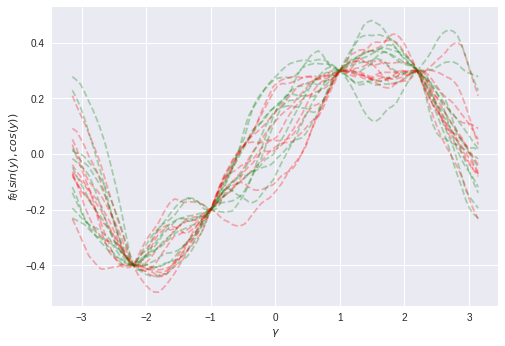

In [10]:
for i in range(10):
  # 1000 width first
  net = FourLayersNet(1000)
  if use_cuda:
    net = net.cuda()
  train_net(net, 1000, input_data, target_data)
  output_vec = net(circle_points).cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='red',
           linestyle='--', alpha = 0.3)
  # 50 width
  net = FourLayersNet(50)
  if use_cuda:
    net = net.cuda()
  train_net(net, 1000, input_data, target_data)
  output_vec = net(circle_points).cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='green',
           linestyle='--', alpha = 0.3)
  
  print('Completed initialisation {}'.format(i))
  
plt.xlabel('$\gamma$')
plt.ylabel('$f_{ \\theta}(sin(y),cos(y))$')
plt.show()
   
   

### Getting the GP process plot is harder (I think) because of a lack of a standard kernel, here is an attempt but it is probably horrifically inefficient

In [0]:
n_pts=100
n_width = 10000

In [0]:
# number of points in plot
grad_mat = torch.zeros((n_pts,4))
net = FourLayersNet(n_width)
if use_cuda:
  net.cuda()

In [0]:
gamma_test = torch.tensor(np.linspace(-np.pi,np.pi, n_pts))
initial_train = net(input_data) # this acts of f_0 on page 7 of NTK paper
initial_test = net(circle_transform(gamma_test).cuda())

In [0]:
train_net(net, 1000, input_data, target_data)

In [0]:
# saves gradient objects onto cpu, saves GPU memory
def cpu_tuple(tuple_obj):
  return tuple([obj.cpu() for obj in tuple_obj])

In [0]:
grad_list = []
for gamma in gamma_data:
  circle_pt = circle_transform(gamma)
  if use_cuda and torch.cuda.is_available():
    circle_pt = circle_pt.cuda()
  loss = net(circle_pt)
  grad_list.append(cpu_tuple(torch.autograd.grad(loss,net.parameters(), retain_graph = True)))

In [17]:
%%time
# grad_mat is kappa on p7 of NTK paper
for i, gamma in enumerate(gamma_test):
  if i%10 == 0:
    print('point {}'.format(i))
  circle_pt = circle_transform(gamma)
  if use_cuda and torch.cuda.is_available():
    circle_pt = circle_pt.cuda()
  loss = net(circle_pt)
  grads = cpu_tuple(torch.autograd.grad(loss,net.parameters(), retain_graph = True)) # extract NN gradients 
  for j in range(len(grad_list)):
    pt_grad = grad_list[j] # the gradients at the jth (out of 4) data point
    grad_mat[i, j] = sum([torch.sum(torch.mul(grads[u], pt_grad[u])) for u in range(len(grads))])

point 0
point 10
point 20
point 30
point 40
point 50
point 60
point 70
point 80
point 90
CPU times: user 3min 42s, sys: 5.33 s, total: 3min 47s
Wall time: 3min 47s


In [0]:
# let's create Ktilde matrix from p7 of NTK paper
tilde_mat = torch.zeros((4,4))
for i in range(4):
  grad_i = grad_list[i]
  for j in range(i+1):
    grad_j = grad_list[j]
    tilde_mat[i, j] = sum([torch.sum(torch.mul(grad_i[u], grad_j[u])) for u in range(len(grad_j))])
    tilde_mat[j, i] = tilde_mat[i, j]
    
tilde_inv = torch.inverse(tilde_mat)

In [0]:
temp_mat = torch.mm(grad_mat, tilde_inv)

In [0]:
target_data = target_data.cpu()

In [0]:
mean_vec = torch.mm(temp_mat, target_data.unsqueeze(1)) #+ initial_test.cpu() - torch.mm(temp_mat, initial_train.cpu())
np.save('mean_vec.npy', mean_vec.numpy())
files.download('mean_vec.npy')

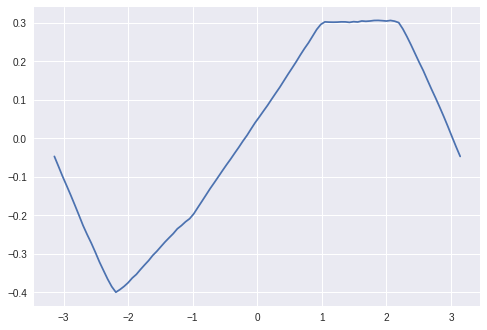

In [24]:
plt.plot(gamma_test.numpy(), mean_vec.detach().numpy())

### It remains to estimate sigma matrix

In [0]:
variance_vec = variance_est(10000, 100, temp_mat, 10000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


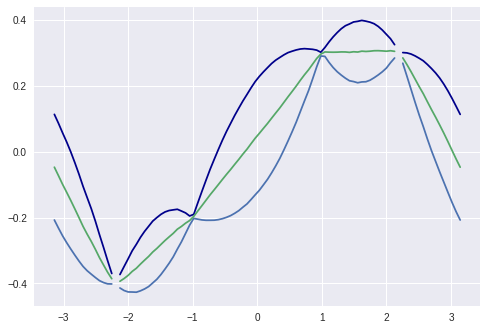

In [26]:
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+1.28*np.sqrt(variance_vec.detach().numpy()), color = 'darkblue')
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()-1.28*np.sqrt(variance_vec.detach().numpy()))
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+0*np.sqrt(variance_vec.detach().numpy()))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


Completed initialisation 0
Completed initialisation 1
Completed initialisation 2
Completed initialisation 3
Completed initialisation 4
Completed initialisation 5
Completed initialisation 6
Completed initialisation 7
Completed initialisation 8
Completed initialisation 9


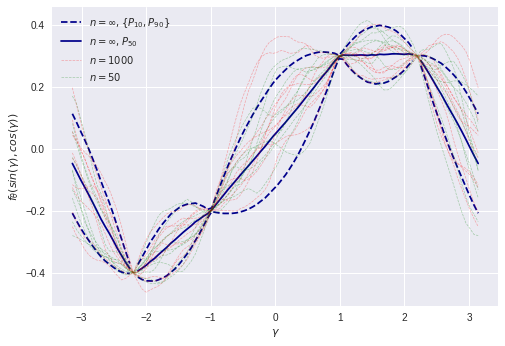

In [27]:
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+1.28*np.sqrt(variance_vec.detach().numpy()),
         color='darkblue', linestyle = '--')
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()-1.28*np.sqrt(variance_vec.detach().numpy()), 
         color='darkblue', linestyle = '--', label = '$n=\infty, \{P_{10}, P_{90}\}$')
plt.plot(gamma_test.numpy(), mean_vec.view(-1).detach().numpy()+0*np.sqrt(variance_vec.detach().numpy()), 
         color='darkblue', label = '$n=\infty, P_{50}$')

for i in range(10):
  # 1000 width first
  net = FourLayersNet(1000)
  if use_cuda:
    net = net.cuda()
  train_net(net, 1000, input_data, target_data.cuda())
  output_vec = net(circle_points).cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='red',
           linestyle='--', alpha = 0.3, label = '$n=1000$', linewidth = 0.7)
 # 50 width
  net = FourLayersNet(50)
  if use_cuda:
    net = net.cuda()
  train_net(net, 1000, input_data, target_data.cuda())
  output_vec = net(circle_points).cpu()
  plt.plot(gamma_vec.numpy(), output_vec.detach().numpy(), color='green',
           linestyle='--', alpha = 0.3,  label = '$n=50$', linewidth = 0.7)
  
  print('Completed initialisation {}'.format(i))

plt.xlabel('$\gamma$')
plt.ylabel('$f_{ \\theta}(sin(\gamma),cos(\gamma))$')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc = 'upper left')
plt.savefig('6pt2.pdf')
files.download('6pt2.pdf')
plt.show()